In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd /content/drive/MyDrive/BDA-Project

/content/drive/MyDrive/BDA-Project


In [ ]:
#Loading Dependencies

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
import time
import pandas as pd
import pandas.util.testing as tm
from sklearn.utils import class_weight
from google.colab.patches import cv2_imshow

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import tensorflow as tf

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/BDA-Project/aptos2019-blindness-detection/train.csv")
print("train.csv:")
print("Number of Training images: {}\n".format(train_data.shape[0]))
print(train_data.head(2),"\n")
print("-"*100)
test_data = pd.read_csv("/content/drive/MyDrive/BDA-Project/aptos2019-blindness-detection/test.csv")
print("test.csv: ")
print("Number of Testing images: {}\n".format(test_data.shape[0]))
print(test_data.head(2))
print("\n","-"*100)
print("sample_submission.csv:")
sample_submission = pd.read_csv("/content/drive/MyDrive/BDA-Project/aptos2019-blindness-detection/sample_submission.csv")
print("The format of submitting the final predictions on testing images: ")
print(sample_submission.head(5))

train.csv:
Number of Training images: 3662

        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4 

----------------------------------------------------------------------------------------------------
test.csv: 
Number of Testing images: 1928

        id_code
0  0005cfc8afb6
1  003f0afdcd15

 ----------------------------------------------------------------------------------------------------
sample_submission.csv:
The format of submitting the final predictions on testing images: 
        id_code  diagnosis
0  0005cfc8afb6          0
1  003f0afdcd15          0
2  006efc72b638          0
3  00836aaacf06          0
4  009245722fa4          0


In [ ]:
# Intialization of variables which are useful for the later tasks.
img_width = 512
img_height = 512
no_channels = 3
split_size = 0.15
class_labels = {0: 'No DR[0]',1: 'Mild[1]', 2: 'Moderate[2]', 3: 'Severe[3]', 4: 'Proliferative DR[4]'}


In [ ]:
class_labels_ = list(set(train_data['diagnosis']))
print("Number of target classes: {}".format(class_labels_))

Number of target classes: [0, 1, 2, 3, 4]


In [ ]:
#Splitting the Dataset:
'''def splitting_data(train_data, size, is_split = True):

    try:
        if is_split:
            data = train_data['id_code']
            labels = train_data['diagnosis']
            train_x, validation_x, train_labels, validation_labels = train_test_split(data, labels, stratify=labels, shuffle=True, test_size=size)
            print("Training data: {} {}".format(train_x.shape, train_labels.shape))
            print("Validation data: {} {}".format(validation_x.shape,validation_labels.shape))
            return train_x, train_labels, validation_x, validation_labels
        else:
            return train_data['id_code'], train_data['diagnosis'], [], []
    except:
        print("Error: Invalid file format, Function argument requires .csv file")'''

In [ ]:
train_x, train_labels, validation_x, validation_labels = splitting_data(train_data, split_size)


Training data: (3112,) (3112,)
Validation data: (550,) (550,)


In [ ]:
#Saving files into folders for future use:
'''

train = pd.DataFrame(train_x, columns = ['id_code'])
train['diagnosis'] = train_labels
train.to_csv("/content/drive/MyDrive/BDA-Project/training.csv", index = False)
validation = pd.DataFrame(validation_x, columns = ['id_code'])
validation['diagnosis'] = validation_labels
validation.to_csv('/content/drive/MyDrive/BDA-Project/validation.csv', index = False)

test = pd.read_csv('/content/drive/MyDrive/BDA-Project/aptos2019-blindness-detection/test.csv')
test.to_csv('/content/drive/MyDrive/BDA-Project/test.csv', index = False)'''


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/BDA-Project/training.csv")
validation = pd.read_csv("/content/drive/MyDrive/BDA-Project/validation.csv")

train_x = train['id_code']
train_labels = train['diagnosis']
validation_x = validation['id_code']
validation_labels = validation['diagnosis']

In [ ]:
class ImageProcessing:
    def __init__(self, img_height, img_width, no_channels, tol=7, sigmaX=8):

        ''' Initialzation of variables'''

        self.img_height = img_height
        self.img_width = img_width
        self.no_channels = no_channels
        self.tol = tol
        self.sigmaX = sigmaX

    def cropping_2D(self, img, is_cropping = False):

        mask = img>self.tol
        return img[np.ix_(mask.any(1),mask.any(0))]

    def cropping_3D(self, img, is_cropping = False):

        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>self.tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # if image is too dark we return the image
            return img
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]  #for channel_1 (R)
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]  #for channel_2 (G)
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]  #for channel_3 (B)
            img = np.stack([img1,img2,img3],axis=-1)
        return img

    def Gaussian_blur(self, img, is_gaussianblur = False):


        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img,(0,0),self.sigmaX),-4,128)
        return img

    def draw_circle(self,img, is_drawcircle = True):

        x = int(self.img_width/2)
        y = int(self.img_height/2)
        r = np.amin((x,y))     # finding radius to draw a circle from the center of the image
        circle_img = np.zeros((img_height, img_width), np.uint8)
        cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
        img = cv2.bitwise_and(img, img, mask=circle_img)
        return img

    def image_preprocessing(self, img, is_cropping = True, is_gaussianblur = True):


        if img.ndim == 2:
            img = self.cropping_2D(img, is_cropping)  #calling cropping_2D for a GRAY image
        else:
            img = self.cropping_3D(img, is_cropping)  #calling cropping_3D for a RGB image
        img = cv2.resize(img, (self.img_height, self.img_width))  # resizing the image with specified values
        img = self.draw_circle(img)  #calling draw_circle
        img = self.Gaussian_blur(img, is_gaussianblur) #calling Gaussian_blur
        return img

In [ ]:
def images_per_class(class_labels,num, data_x , is_preprocess = False):


    # class_labels num data_x data_y
    labels = list(set(class_labels))
    classes = ['No DR','Mild','Moderate','Severe','Proliferative DR']
    iter=0
    for i in labels:
        j=1
        plt.figure(figsize=(20,5))
        for row in range(len(data_x)):
            if class_labels.iloc[row] == i:
                if is_preprocess == False:
                  plt.subplot(1,num,j)
                else:
                   plt.subplot(1,num*2,j)
                try:
                  img = cv2.imread('/content/drive/MyDrive/BDA-Project/aptos2019-blindness-detection/train_images/'+data_x.iloc[row]+'.png')
                  img1 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                  plt.imshow(img1)
                  plt.axis('off')
                  plt.title("Class = {} ({})".format(class_labels.iloc[row],classes[iter]))
                except:
                  continue
                j+=1
                if is_preprocess == True:
                    obj = ImageProcessing(img_width,img_height,no_channels,sigmaX=14)
                    image = obj.image_preprocessing(img)
                    plt.subplot(1,num*2,j)
                    plt.imshow(image)
                    plt.axis('off')
                    plt.title('==> After Image Processing')
                    j+=1
            if is_preprocess == False and j>num: break
            elif is_preprocess == True and j>num*2: break
        iter+=1
        plt.show()


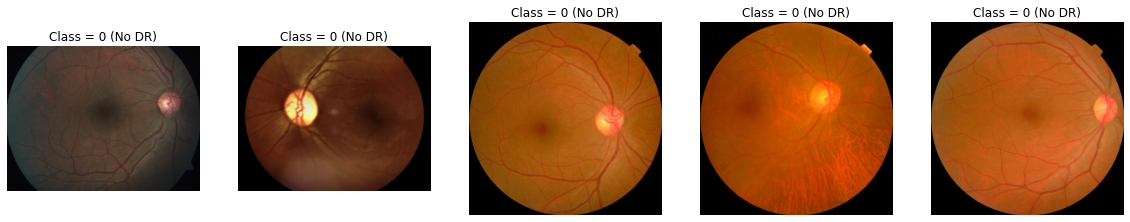

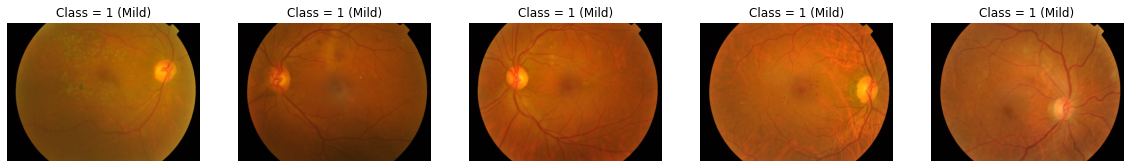

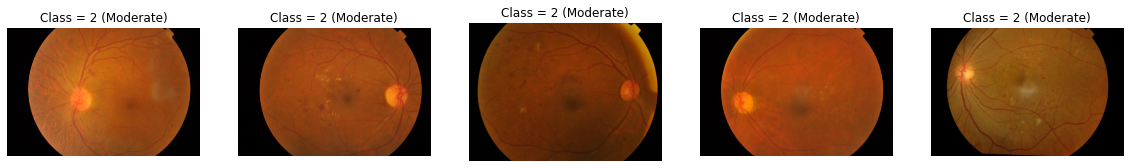

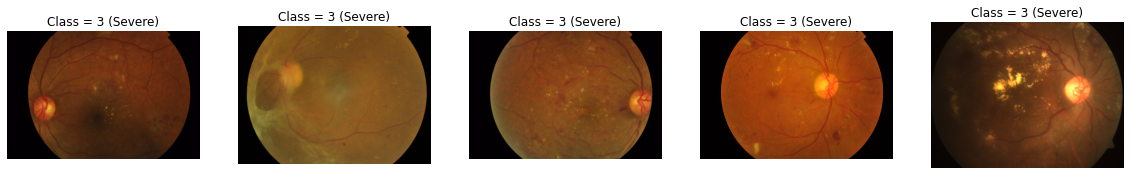

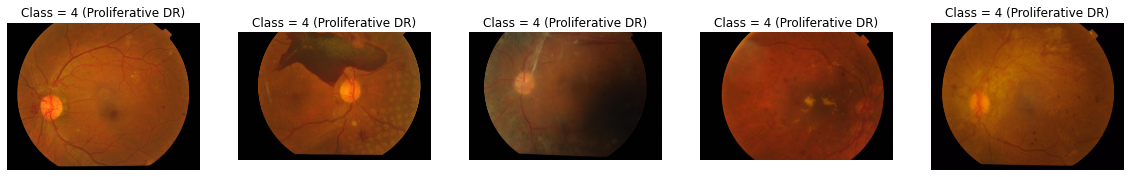

In [ ]:
images_per_class(train_labels,5,train_x,False)


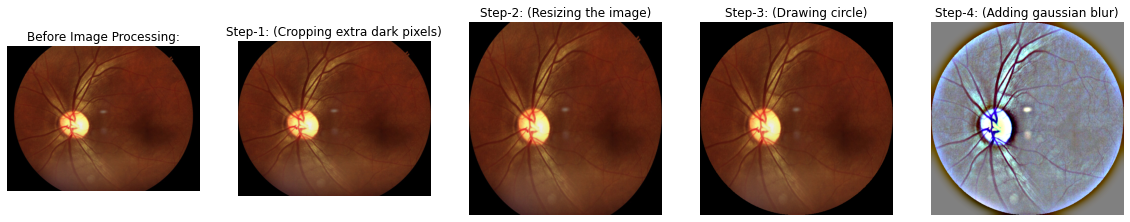

In [ ]:
def plotting(img, title,i):

    plt.subplot(1,5,i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
obj1 = ImageProcessing(img_width,img_height, no_channels, sigmaX = 14)
img = '/content/drive/MyDrive/BDA-Project/aptos2019-blindness-detection/train_images/201f882365d3.png'  #random train image
img = cv2.imread(img)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,5))
plotting(img1,'Before Image Processing:',1)
img1 = obj1.cropping_3D(img1)
plotting(img1,'Step-1: (Cropping extra dark pixels)',2)
img1 = cv2.resize(img1, (img_height,img_width))
plotting(img1,'Step-2: (Resizing the image)',3)
img1 = obj1.draw_circle(img1)
plotting(img1,'Step-3: (Drawing circle)',4)
img = obj1.image_preprocessing(img,'True')
plotting(img,'Step-4: (Adding gaussian blur)',5)

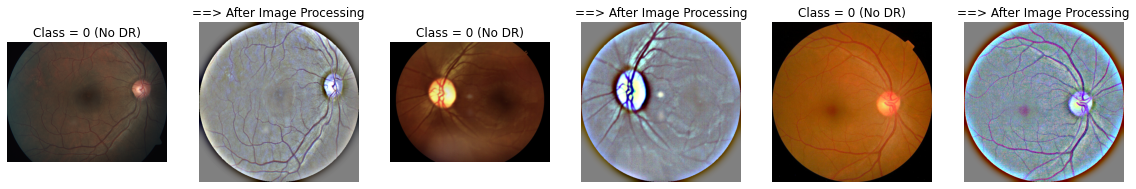

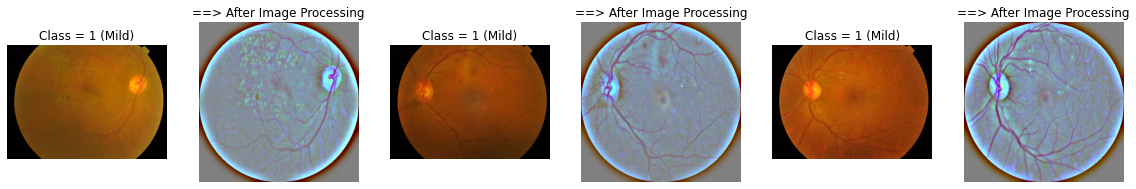

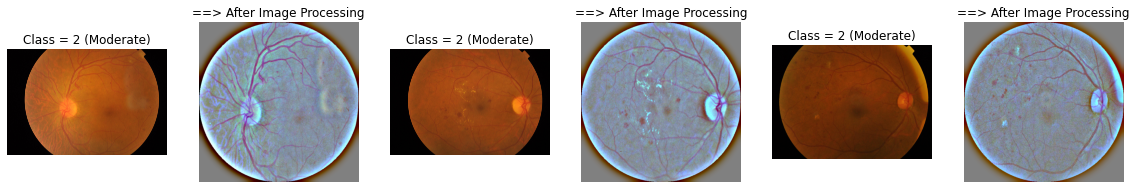

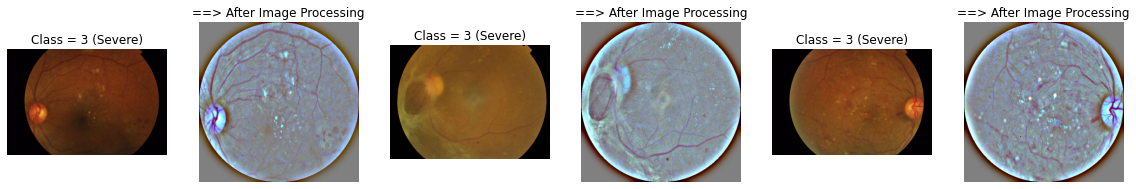

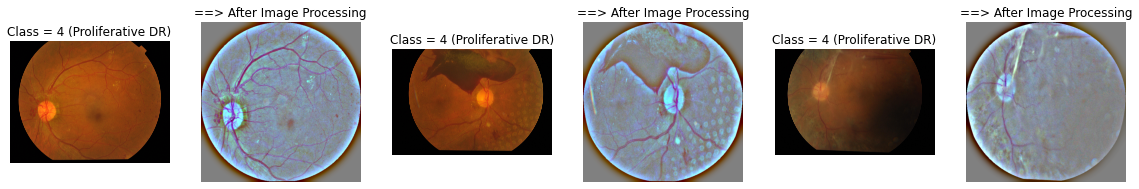

In [ ]:
images_per_class(train_labels,3,train_x,True)

In [ ]:
#Image Coversion

def image_2_vector(data, sep):

    start_time = time.time()  # storing timestamp
    image_vector = np.empty((len(data),img_width, img_height, no_channels), dtype = np.uint8)
    image_processing = ImageProcessing(img_width, img_height, no_channels, sigmaX)  # Object creation
    if sep !='test':
        c = '/content/drive/MyDrive/BDA-Project/aptos2019-blindness-detection/train_images/'
    else:
        c = '/content/drive/MyDrive/BDA-Project/aptos2019-blindness-detection/test_images/'
    for iter,row in enumerate(tqdm(data)):
        img_path = c+data.iloc[iter]+'.png'
        try:
          img = cv2.imread(img_path)
          img = image_processing.image_preprocessing(img)    #calling image_preprocessing
        except:
          continue
        image_vector[iter,:,:,:] = img

    if sep == 'training': print("\nShape of the vector:",image_vector.shape)
    else: print("\n\nShape of the vector:",image_vector.shape)
    print("Time taken to process the {} images: {} seconds".format(sep,np.round(time.time()-start_time,5)))
    path = '/content/drive/My Drive/BDA_Project/processed_images'
    print("... Saving image_vector to {}".format(path+'/'+sep))

    if sep == 'training':
        print("\n","-"*100,"\n")
    if not os.path.exists(path):
        os.makedirs(path)
    np.save(path+'/'+sep+'.npy', image_vector)  #saving file

In [ ]:
sigmaX = 14
image_2_vector(train_x, "training") # function calling
image_2_vector(validation_x,"validation")  #function calling

100%|██████████| 3112/3112 [11:40<00:00,  4.44it/s]



Shape of the vector: (3112, 512, 512, 3)
Time taken to process the training images: 700.38128 seconds
... Saving image_vector to /content/drive/My Drive/BDA-Project/processed_images/training

 ---------------------------------------------------------------------------------------------------- 



100%|██████████| 550/550 [02:10<00:00,  4.21it/s]




Shape of the vector: (550, 512, 512, 3)
Time taken to process the validation images: 130.74821 seconds
... Saving image_vector to /content/drive/My Drive/BDA-Project/processed_images/validation


In [ ]:
test = pd.read_csv("/content/drive/My Drive/BDA-Project/aptos2019-blindness-detection/test.csv")
image_2_vector(test['id_code'], 'test')

100%|██████████| 1928/1928 [11:04<00:00,  2.90it/s]




Shape of the vector: (1928, 512, 512, 3)
Time taken to process the test images: 664.93391 seconds
... Saving image_vector to /content/drive/My Drive/BDA-Project/processed_images/test


In [ ]:
try:
    x_train = np.load("/content/drive/My Drive/BDA-Project/processed_images/training.npy", mmap_mode=None, allow_pickle=False, fix_imports=True)
    x_validation = np.load("/content/drive/My Drive/BDA-Project/processed_images/validation.npy",mmap_mode=None, allow_pickle=False, fix_imports=True)
    x_test = np.load("/content/drive/My Drive/BDA-Project/processed_images/test.npy", mmap_mode = None,allow_pickle = False, fix_imports = True)
    print("Loaded Successfully...\n")
    print(x_train.shape)
    print(x_validation.shape)
    print(x_test.shape)
except:
    print("file not exists")



Loaded Successfully...

(3112, 512, 512, 3)
(550, 512, 512, 3)
(1928, 512, 512, 3)


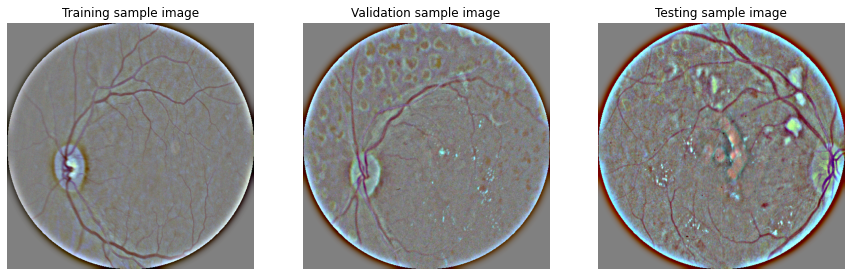

In [ ]:
#Testing

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(x_train[131])   #random training example
plt.axis('off')
plt.title("Training sample image")
plt.subplot(132)
plt.imshow(x_validation[120])    #random validation example
plt.title("Validation sample image")
plt.axis('off')
plt.subplot(133)
plt.imshow(x_test[1200])        #random test example
plt.title("Testing sample image")
plt.axis('off')
plt.show()

In [ ]:
def ordinal_encoding(labels):
    """
    This function is used to create one_hot_encoding of the labels.
    E.x: category = 3 -> one-hot-encoding [1,1,1,1,0].
         category = 2 -> one-hot-encoding [1,1,1,0,0].
    """
    y_train = pd.get_dummies(labels).values
    y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
    y_train_multi[:, 4] = y_train[:, 4]

    for i in range(3, -1, -1):
         y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])
    return y_train_multi
labels_train = ordinal_encoding(train_labels)
labels_validation = ordinal_encoding(validation_labels)
print(labels_train.shape)
print(labels_validation.shape)
print("Ex: Original Category: {}\n After one_hot_encoding: {}\n".format(train_labels.iloc[4],labels_train[4]))
print("Ex: Original Category: {}\n After ordinal encoding: {}\n".format(train_labels.iloc[15],labels_train[15]))
#print("Ex: Original Category: {}\n After ordinal encoding: {}\n".format(train_labels.iloc[1],labels_train[1]))
#print("Ex: Original Category: {}\n After ordinal encoding: {}\n".format(train_labels.iloc[4],labels_train[4]))
#print("Ex: Original Category: {}\n After ordinal encoding: {}\n".format(train_labels.iloc[3],labels_train[3]))

(3112, 5)
(550, 5)
Ex: Original Category: 4
 After one_hot_encoding: [1 1 1 1 1]

Ex: Original Category: 1
 After ordinal encoding: [1 1 0 0 0]



In [ ]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique([0,1,2,3,4]),
                                        y = train_labels
                                    )
class_weights = dict(zip(np.unique([0,1,2,3,4]), class_weights))
print(class_weights)

{0: 0.4057366362451108, 1: 1.9821656050955414, 2: 0.7330977620730271, 3: 3.795121951219512, 4: 2.4796812749003982}


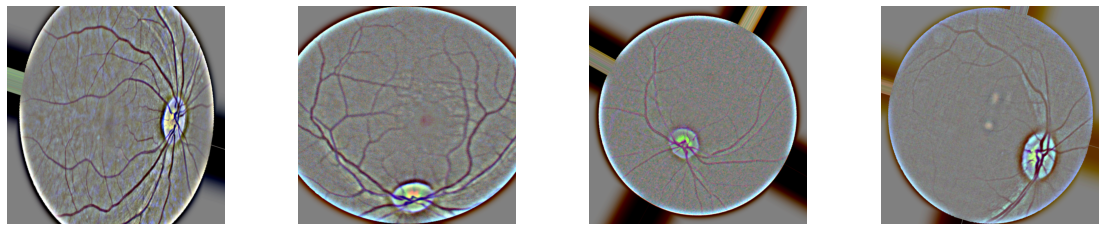

In [ ]:
#Data Augmentation
data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=180,zoom_range = 0.2)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
it = 0
for x, y in data_generator.flow(x_train,train_labels):
    ax[it].imshow((x[0]).astype('uint8'))
    ax[it].axis('off')
    it += 1
    if it == 4:
        break

In [ ]:
#Densenet

def GAP2D():
    '''Global average pooling layer'''
    global_average_pooling = GlobalAveragePooling2D()
    return global_average_pooling
def dropout(value = 0.5):
    '''Dropout layer'''
    dropout_layer = Dropout(value)
    return dropout_layer
def dense():
    '''Dense layer'''
    dense_layer = Dense(5, activation='sigmoid')
    return dense_layer

global_average_pooling_layer = GAP2D()
dropout_layer = dropout()
dense_layer = dense()

def DenseNet():
    '''This function is used for building a model architecture of pretrained Densenet121 on imagenet data set.'''
    densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(512,512,3))
    x = global_average_pooling_layer(densenet.layers[-1].output)
    x = dropout_layer(x)
    output = dense_layer(x)
    model = Model(densenet.layers[0].input,output)
    model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(lr=0.00005), metrics=['accuracy'])
    return model

In [ ]:
densenet = DenseNet()
densenet.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 256, 256, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [ ]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('densenet_model_7_epochs.h5', verbose=1, save_best_only=True)
data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=180,zoom_range = 0.2)
densenet = DenseNet()
history = densenet.fit_generator(
                   data_generator.flow(x_train, labels_train, batch_size=8),
                    steps_per_epoch=len(x_train) / 8,
                    epochs=30,
                    initial_epoch=0,
                    verbose=1,
                    validation_data=(x_validation, labels_validation),
                    validation_steps=len(x_validation) / 8,
                    callbacks=[anne, checkpoint],
                    class_weight = class_weights)

In [ ]:
densenet.load_weights("/content/drive/My Drive/BDA-Project/densenet_model_7_epochs.h5")

In [ ]:
result = densenet.evaluate(x_validation,labels_validation)
y_pred = densenet.predict(x_validation)
print("After running the model for 7 epochs, Accuracy = {} on validation data".format(np.round(result[1],4)))

18/18 [==============================] - 208s 11s/step - loss: 0.0931 - accuracy: 0.7273
After running the model for 7 epochs, Accuracy = 0.7273 on validation data


In [ ]:

class PerformanceMetric:
    def __init__(self,actual_labels,predicted_labels):
        ''' Initialization of variables '''
        self.actual_labels = actual_labels
        self.predicted_labels = predicted_labels
    def single_value_conversion(self):
        ''' This function is used for Converting model predicted values into single values
           Ex: model_predicted_value: [0,1,0,0,0] and it converts as 1'''
        predicted_labels = self.predicted_labels > 0.5
        prediction_ordinal = np.empty(predicted_labels.shape, dtype = int)
        prediction_ordinal[:,4] = predicted_labels[:,4]
        for i in range(3, -1, -1): prediction_ordinal[:, i] = np.logical_or(predicted_labels[:,i], prediction_ordinal[:,i+1])
        self.predicted_labels = prediction_ordinal.sum(axis = 1)-1
        self.actual_labels = self.actual_labels.sum(axis = 1)-1
    def confusionMatrix(self):
        ''' This function is used for calculating confusion matrix between model predicted values and true values using sklearn implementation.'''
        confusion_matrix_ = confusion_matrix(self.actual_labels, self.predicted_labels)
        return confusion_matrix_
    def precision(self, matrix):
        ''' This function is used for calculating precision matrix between predicted values and true values using confusion matrix'''
        precision_matrix =(((matrix.T)/(matrix.sum(axis=1))).T)
        return precision_matrix
    def recall(self, matrix):
        ''' this function is used for calculating recall matrix between predicted values and true values using confusion matrix'''
        recall_matrix =(matrix/matrix.sum(axis=0))
        return recall_matrix
    def subplot_(self, matrix, i, title):
        ''' This function is used for subplots'''
        plt.subplot(1,3,i)
        labels = [0,1,2,3,4,]
        sns.heatmap(matrix, annot=True, cmap=sns.light_palette('green'),linewidths = 0.8,cbar = False, fmt=".3f", xticklabels=labels, yticklabels=labels)
        plt.title(title)
        plt.xlabel('Predicted Class Labels')
        plt.ylabel('Actual Class Labels')
    def plotting(self):
        """
        This function is used for calculating number of misclassified points, confusion, recall and precision matrixes and plotting it using subplots.
        """
        self.single_value_conversion()
        confusion_matrix = self.confusionMatrix()
        #print("Number of misclassified points: ",(len(self.actual_labels)-np.trace(confusion_matrix))/len(self.actual_labels)*100,"\n")
        precision_matrix = self.precision(confusion_matrix)
        recall_matrix = self.recall(confusion_matrix)
        plt.figure(figsize=(20,5))
        self.subplot_(confusion_matrix, 1, 'Confusion Matrix')
        self.subplot_(precision_matrix, 2, 'Precision')
        self.subplot_(recall_matrix, 3, 'Recall')
        plt.show()



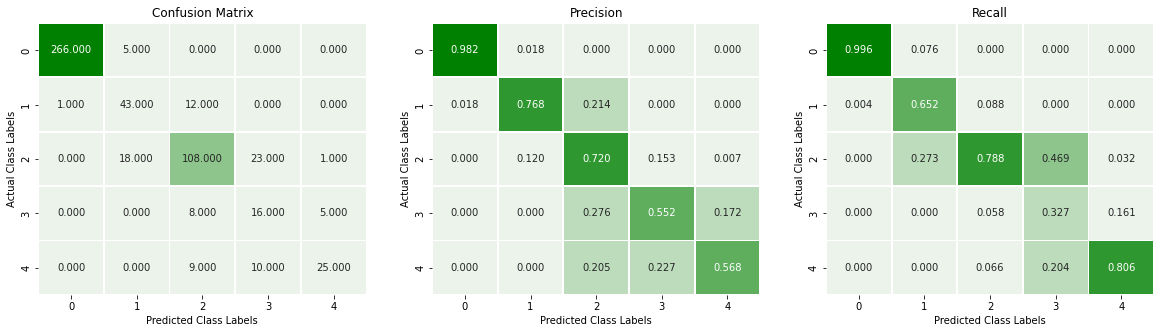

In [ ]:
metric = PerformanceMetric(labels_validation, y_pred)
metric.plotting()

In [ ]:
def test_prediction(predicted_labels):
    '''
    Making predictions of the probability scores. The class with more score will be taken as predicted class.
    Arguments:
    predicted_labels - (np.array) - probability score of given sample
    '''
    predicted_labels = predicted_labels > 0.5
    prediction_ordinal = np.empty(predicted_labels.shape, dtype = int)
    prediction_ordinal[:,4] = predicted_labels[:,4]
    for i in range(3, -1, -1): prediction_ordinal[:, i] = np.logical_or(predicted_labels[:,i], prediction_ordinal[:,i+1])
    predicted_labels = prediction_ordinal.sum(axis = 1)-1
    return predicted_labels

In [ ]:
def plot_predictions(data,label):

    def plot(row,col,index,img,title=None):
        ''' plotting individual images '''
        plt.subplot(row,col,index)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    count=0
    for i in range(3):   ### for each row (3 here)
        iter=0
        fig=plt.figure(figsize=(20,5))
        for j in range(2):   ### for each column (2 here)

            org_img = cv2.imread('/content/drive/MyDrive/BDA-Project/aptos2019-blindness-detection/train_images/'+id[count]+'.png')
            orginal_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)
            img=ip(org_img)
            plot(1,6,iter+1,orginal_img,id[count])

            iter+=1
            img_ = np.expand_dims(img,axis=0)
            pred = densenet.predict(img_)      ### predicting class label using densenet
            pred = test_prediction(pred)

            plot(1,6,iter+1,img,'Target Class: '+str(label))
            iter+=1
            plot(1,6,iter+1,img,'Predicted Class: '+str(int(pred)))
            iter+=1
            count+=1


In [ ]:
validation_id= pd.read_csv('validation.csv')
validation_id = validation_id['id_code']

In [ ]:
def ip(img):
  obj = ImageProcessing(img_width,img_height, no_channels, sigmaX = 14)
  img = obj.image_preprocessing(img,'True')
  return img

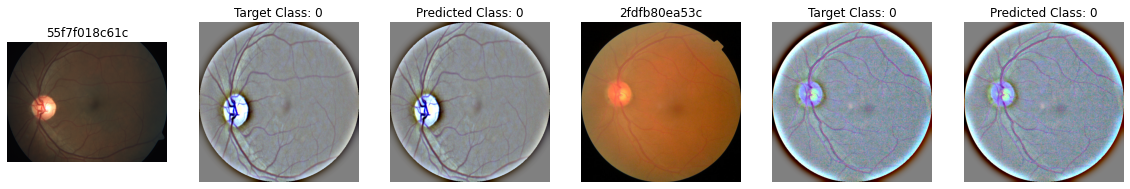

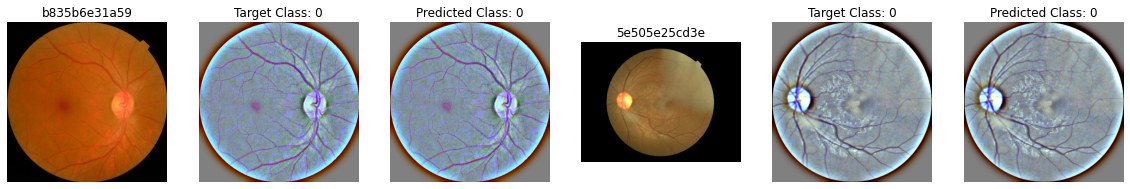

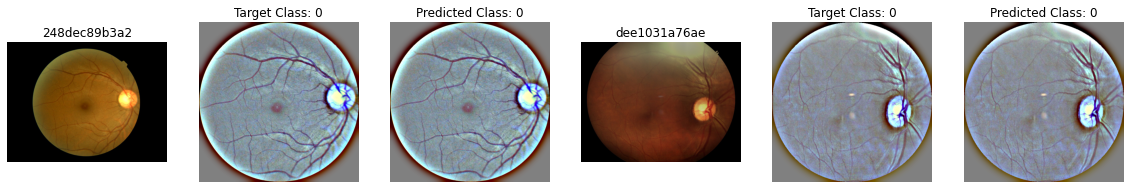

In [ ]:
#predictions for class 0
data = []
id=[]
label=0
for i in range(len(validation_labels)):
    if validation_labels[i]==label:
       data.append(x_validation[i])
       id.append(validation_id[i])

id=id[37:44]

plot_predictions(data,label)

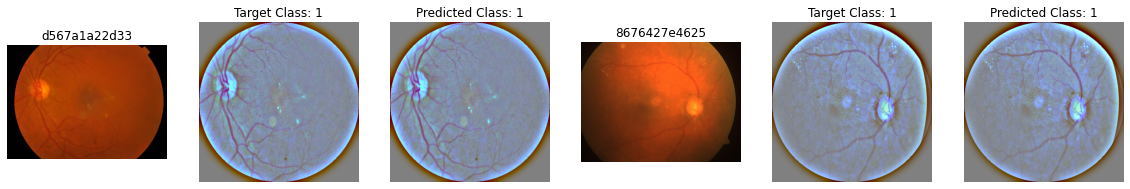

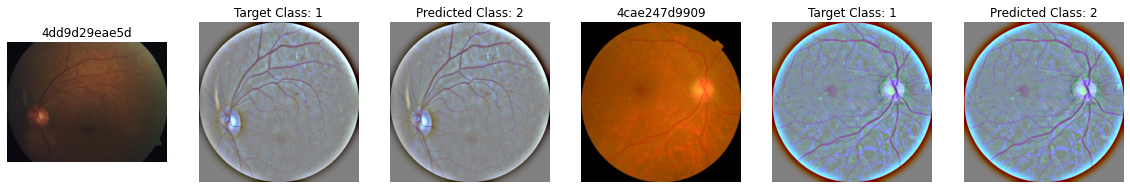

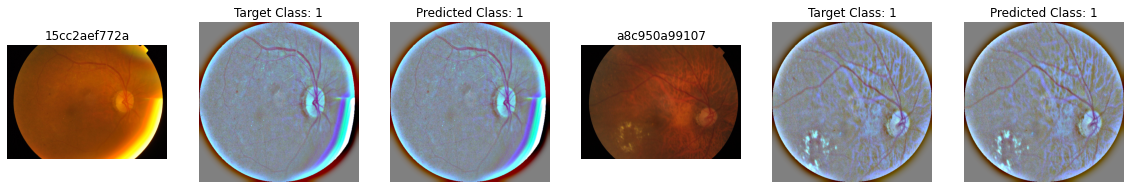

In [ ]:
#predictions for class 1
data = []
id=[]
label=1
for i in range(len(validation_labels)):
    if validation_labels[i]==label:
       data.append(x_validation[i])
       id.append(validation_id[i])

id=id[4:10]

plot_predictions(data,label)

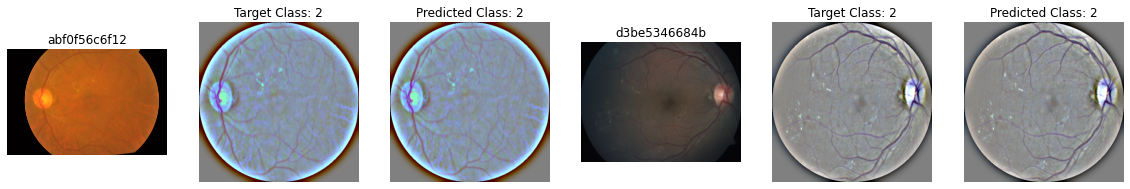

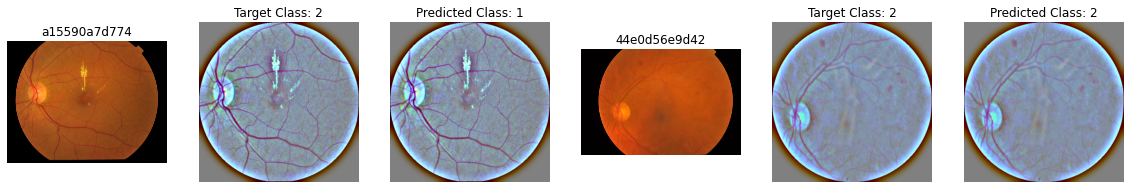

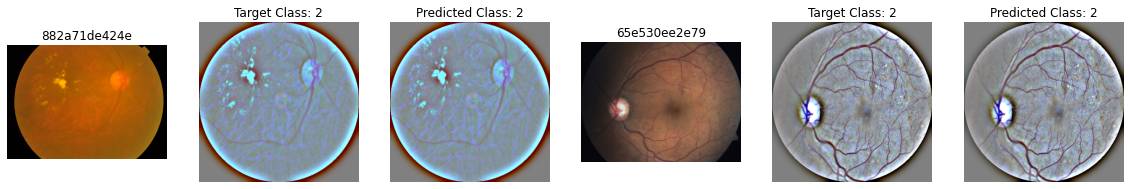

In [ ]:
#predictions for class 2

data = []
id=[]

for i in range(len(validation_labels)):
    if validation_labels[i]==2:
       data.append(x_validation[i])
       id.append(validation_id[i])


id=id[10:16]

plot_predictions(data,2)

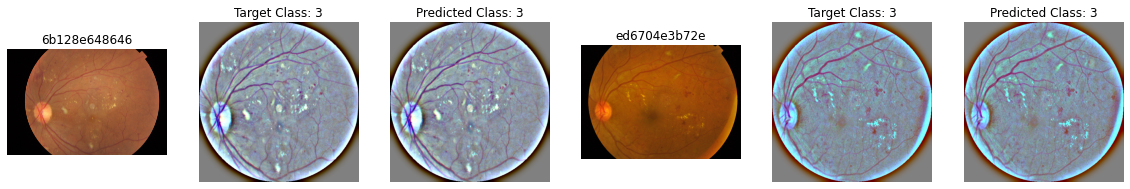

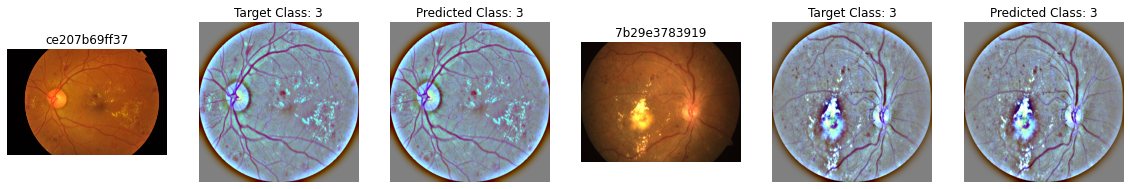

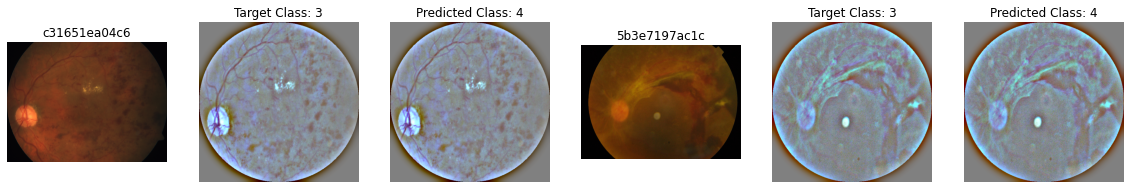

In [ ]:
#predictions for class 3

data = []
id=[]

for i in range(len(validation_labels)):
    if validation_labels[i]==3:
       data.append(x_validation[i])
       id.append(validation_id[i])


id=id[10:16]

plot_predictions(data,3)

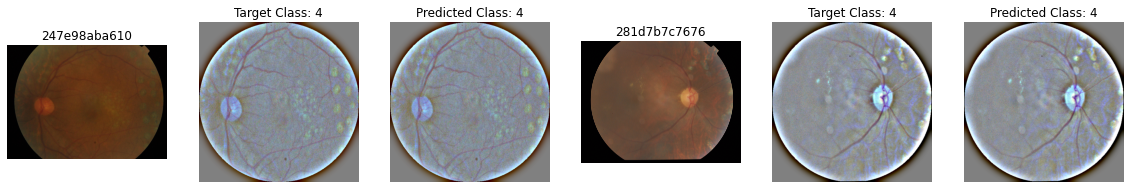

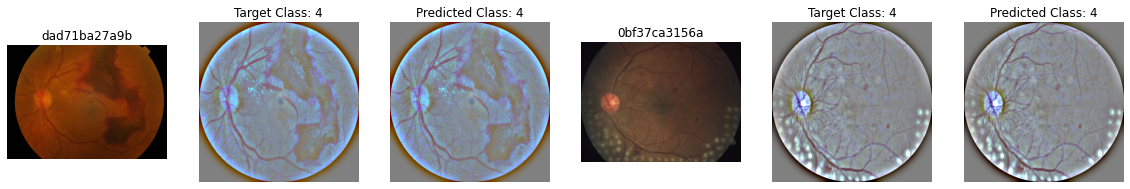

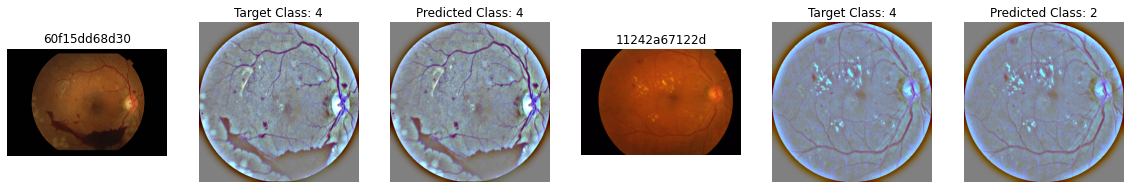

In [ ]:
#predictions for class 4

data = []
id=[]

for i in range(len(validation_labels)):
    if validation_labels[i]==4:
       data.append(x_validation[i])
       id.append(validation_id[i])


id=id[37:44]

plot_predictions(data,4)